### Predicting Emotional Sentiment

In [2]:
import pandas as pd
import numpy as np
import nltk
import contractions
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
# import nltk
# nltk.download('punkt', download_dir='Users/kenchatg/local/share/nltk_data')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# _ = nltk.download('stopwords', quiet=True)
# _ = nltk.download('punkt', quiet=True)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

In [3]:
# Initialize lemmatizer

lemmatizer = WordNetLemmatizer()

# Get stopwords
stop_words = set(stopwords.words('english'))

# Add custom stopwords specific to mental health domain
custom_stopwords = {'feel', 'feeling', 'feelings', 'like', 'would', 'could', 'should', 'get', 'got', 'getting', 'go', 'going', 'went', 'gone'}
stop_words.update(custom_stopwords)

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) 
              for word in tokens 
              if word not in stop_words and len(word) > 2]
    
    return ' '.join(tokens)

In [4]:
# Load the dataset
data = pd.read_csv('mental_health_data.csv')

# Preprocessing

# Remove the rows with missing values
data = data.dropna()

# Remove the rows with repeated entries in the statement column
data = data.drop_duplicates(subset='statement')

# Apply preprocessing
data['processed_text'] = data['statement'].apply(preprocess_text)

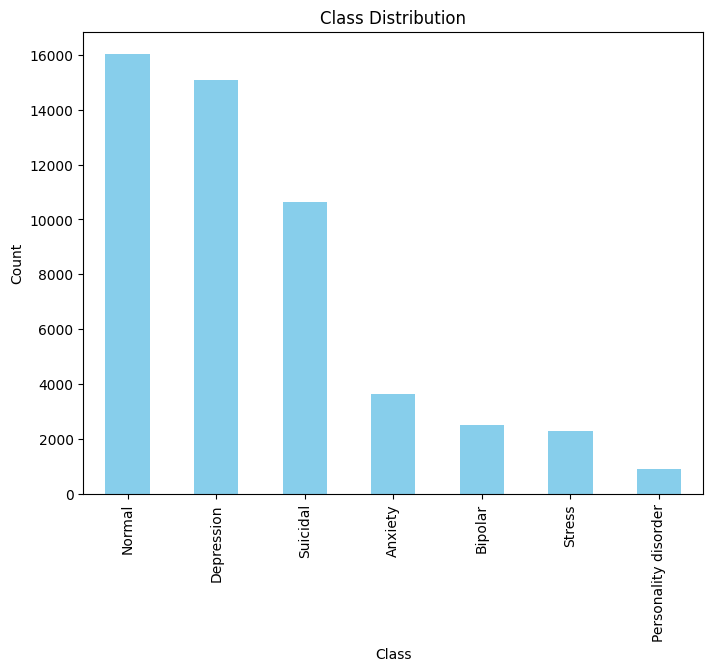

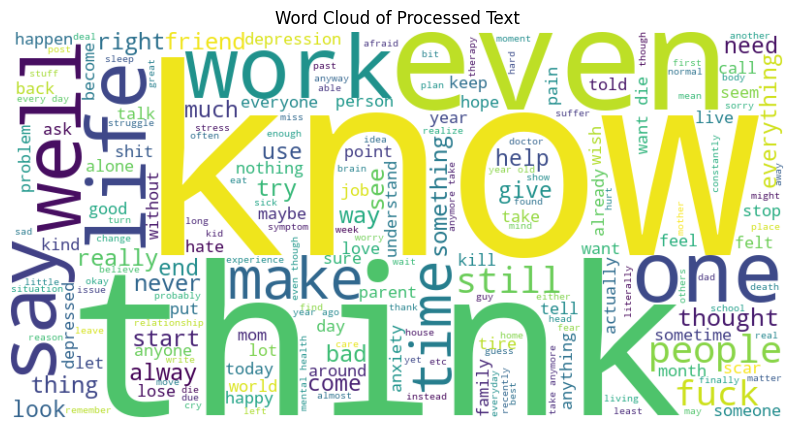

In [5]:
! pip install wordcloud
from collections import Counter
from wordcloud import WordCloud

# Plot class distribution
plt.figure(figsize=(8, 6))
data['status'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Generate a word cloud for the processed text
all_words = ' '.join(data['processed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Processed Text')
plt.show()

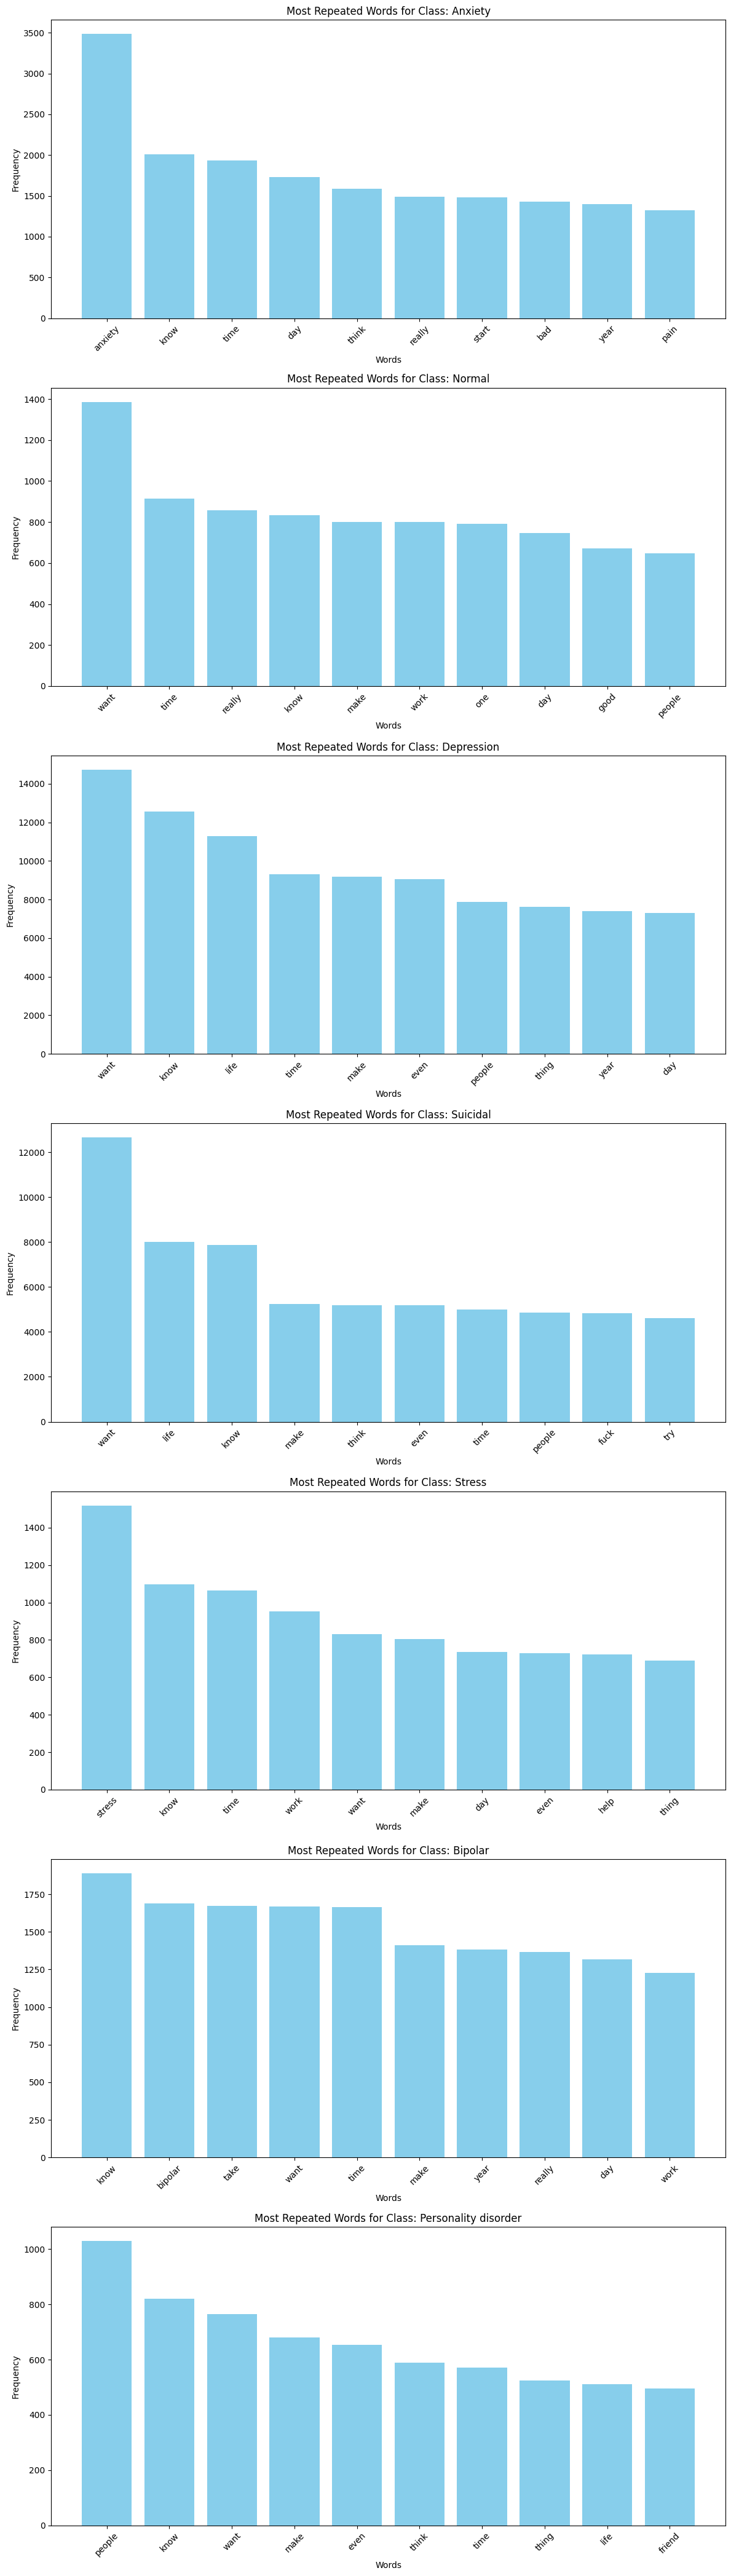

In [6]:
from collections import Counter
# Group data by class and count word frequencies for each class
class_word_counts = {}
for cls in data['status'].unique():
    filtered_data = data[data['status'] == cls]
    word_counts = Counter(' '.join(filtered_data['processed_text']).split())
    class_word_counts[cls] = word_counts.most_common(10)  # Top 10 words for each class

# Plot the graph for each class
fig, axes = plt.subplots(len(class_word_counts), 1, figsize=(12, 6 * len(class_word_counts)))
if len(class_word_counts) == 1:
    axes = [axes]  # Ensure axes is iterable for a single class

for ax, (cls, words_counts) in zip(axes, class_word_counts.items()):
    words, counts = zip(*words_counts)
    ax.bar(words, counts, color='skyblue')
    ax.set_title(f'Most Repeated Words for Class: {cls}')
    ax.set_xlabel('Words')
    ax.set_ylabel('Frequency')
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(data['processed_text'], data['status'], test_size=0.2, random_state=42)

# Create and fit TF-IDF vectorizer with improved parameters
tfidf = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 1),  # Include both unigrams and bigrams
    min_df=3,  # Minimum document frequency
    max_df=0.95,  # Maximum document frequency
    sublinear_tf=True,  # Apply sublinear scaling to term frequencies
    use_idf=True,  # Enable IDF
    smooth_idf=True,  # Smooth IDF weights
    norm='l2'  # Normalize TF-IDF vectors
)

# Transform the text data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [10]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    alpha=0.0001,
    max_iter=1000,
    random_state=42,
    # class_weight='balanced',
    n_jobs=-1  # Use all available cores
)

# Check the unique classes in y_train
unique_classes = y_train.unique()
if len(unique_classes) <= 1:
    raise ValueError(f"The number of classes has to be greater than one; got {len(unique_classes)} class: {unique_classes}")

# Train the model
sgd.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = sgd.predict(X_test_tfidf)

# Print results
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}\n")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7131669114047968


Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.82      0.67      0.74       738
             Bipolar       0.93      0.48      0.64       508
          Depression       0.63      0.71      0.67      2989
              Normal       0.78      0.96      0.86      3294
Personality disorder       1.00      0.10      0.18       194
              Stress       0.81      0.15      0.25       454
            Suicidal       0.64      0.58      0.61      2038

            accuracy                           0.71     10215
           macro avg       0.80      0.52      0.56     10215
        weighted avg       0.72      0.71      0.69     10215



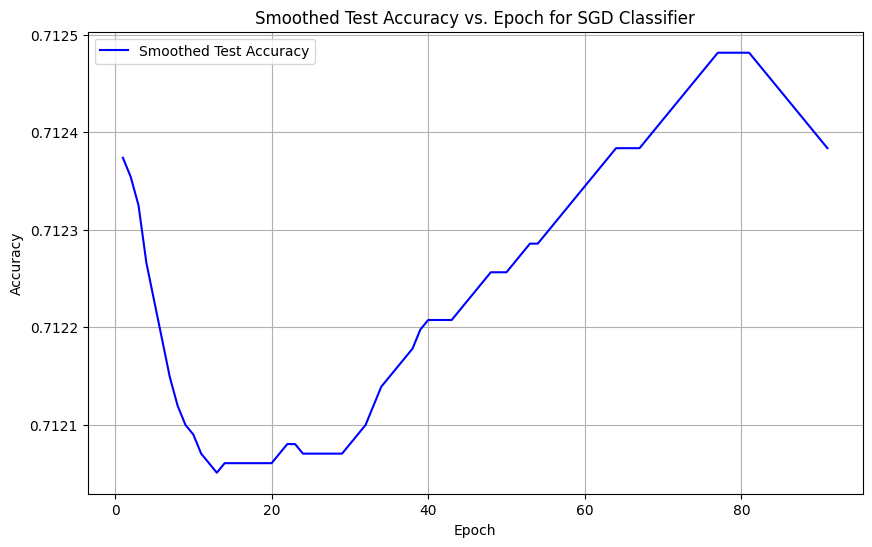

In [11]:
# Initialize variables to track test accuracies
test_accuracies = []
epochs =100  # Number of epochs for training
# Train the model and record test accuracy at each epoch
for epoch in range(1, epochs + 1):
    sgd.partial_fit(X_train_tfidf, y_train, classes=unique_classes)  # Incremental training
    y_test_pred = sgd.predict(X_test_tfidf)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_acc)
    # Smooth the test accuracies using a moving average

window_size = 10  # Increase the window size for smoother curves
smoothed_accuracies = np.convolve(test_accuracies, np.ones(window_size) / window_size, mode='valid')
# Plot the smoothed accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(smoothed_accuracies) + 1), smoothed_accuracies, label='Smoothed Test Accuracy', color='blue')
plt.title('Smoothed Test Accuracy vs. Epoch for SGD Classifier')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Train Multinomial Naive Bayes

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=1.0)  # alpha=1.0 for Laplace smoothing
nb.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = nb.predict(X_test_tfidf)

# Print results
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}\n")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print top features for each class
print("\nTop 10 most important features for each class:")
feature_names = tfidf.get_feature_names_out()
for i, category in enumerate(nb.classes_):
    top10 = np.argsort(nb.feature_log_prob_[i])[-10:]
    print(f"\n{category}:")
    for idx in top10:
        print(f"{feature_names[idx]}: {np.exp(nb.feature_log_prob_[i][idx]):.4f}")

Test Accuracy: 0.6502202643171806


Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.81      0.63      0.71       738
             Bipolar       0.86      0.42      0.57       508
          Depression       0.50      0.79      0.61      2989
              Normal       0.83      0.77      0.80      3294
Personality disorder       0.92      0.06      0.11       194
              Stress       0.76      0.05      0.09       454
            Suicidal       0.67      0.50      0.57      2038

            accuracy                           0.65     10215
           macro avg       0.76      0.46      0.49     10215
        weighted avg       0.70      0.65      0.64     10215


Top 10 most important features for each class:

Anxiety:
time: 0.0040
worry: 0.0040
heart: 0.0040
day: 0.0042
symptom: 0.0043
know: 0.0044
worried: 0.0045
anxious: 0.0046
restless: 0.0070
anxiety: 0.0098

Bipolar:
want: 0.0036
time: 0.0038
really: 0.0038


In [13]:

def predict_all_classes(sentence):
    processed_sentence = preprocess_text(sentence)
    sentence_tfidf = tfidf.transform([processed_sentence])
    class_probabilities = sgd.decision_function(sentence_tfidf)
    class_predictions = {cls: prob for cls, prob in zip(sgd.classes_, class_probabilities[0])}
    
    return class_predictions

def predict_class(sentence):
    processed_sentence = preprocess_text(sentence)
    sentence_tfidf = tfidf.transform([processed_sentence])
    predicted_class = sgd.predict(sentence_tfidf)
    
    return predicted_class[0]

input_sentence = "I am "
predicted_class_all = predict_all_classes(input_sentence)
predicted_class = predict_class(input_sentence)

print(f"The predicted class for the input sentence is: {predicted_class}")

The predicted class for the input sentence is: Normal


In [14]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=None,    # Maximum depth of the tree
    random_state=42,   # Random seed for reproducibility
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1          # Use all available cores
)

# Train the Random Forest classifier using the pre-defined X_train_tfidf and y_train
rf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test_tfidf)

# Print results
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_rf)}\n")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Test Accuracy: 0.6910425844346549


Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.79      0.66      0.72       738
             Bipolar       0.88      0.50      0.64       508
          Depression       0.57      0.71      0.63      2989
              Normal       0.83      0.92      0.87      3294
Personality disorder       1.00      0.22      0.36       194
              Stress       0.78      0.14      0.23       454
            Suicidal       0.60      0.51      0.55      2038

            accuracy                           0.69     10215
           macro avg       0.78      0.52      0.57     10215
        weighted avg       0.71      0.69      0.68     10215



In [15]:
def predict_class_rf(sentence):
    processed_sentence = preprocess_text(sentence)
    sentence_tfidf = tfidf.transform([processed_sentence])
    predicted_class_rf = rf.predict(sentence_tfidf)
    
    return predicted_class_rf[0]
def predict_class_rf_probabilities(sentence):
    processed_sentence = preprocess_text(sentence)
    sentence_tfidf = tfidf.transform([processed_sentence])
    class_probabilities_rf = rf.predict_proba(sentence_tfidf)[0]
    class_probabilities_dict = {cls: prob * 100 for cls, prob in zip(rf.classes_, class_probabilities_rf)}
    
    return class_probabilities_dict

input_sentence = "Anxiety after the gym Ever since I started going to the gym , I have fallen in love with it. I look forward to it everyday as it completely distracts me from whatever it is I might be dealing with in my head. I usually go in the evening and up until then I'm fine. But I swear that drive back from the gym and when I'm sitting in my room all alone, can be extremely excruciating sometimes. The anxiety feels like a balloon going up and up into the sky, eventually it will pop and come back down. It's just an awful feeling, and I feel it almost every time now. I wonder if anyone else has felt it or knows what I'm talking about? It's such a terribly lonely feeling I get. I think what really bothers me more than anything in my life is this belief I have that I am not a good person. I mean it's not like I'm cussing people out or being a dick to anyone. It's more like I treat people like they don't matter or mean anything to me, it's an extremely shitty thing to do. Like I see a lot of the same people every day, and I think normally this would result in you forming a bond with them slowly at least. But it's not like that, everyone that's not in my immediate family just gets kept at arm's length. Even then, the relationships I do have with my family almost seem to be held up by plastic and tape."
predicted_class_rf_probabilities = predict_class_rf_probabilities(input_sentence)
print(f"Predicted class probabilities (in %) for the input sentence: {predicted_class_rf_probabilities}")

predicted_class_rf = predict_class_rf(input_sentence)
print(f"The predicted class for the input sentence is: {predicted_class_rf}")

Predicted class probabilities (in %) for the input sentence: {'Anxiety': 3.0, 'Bipolar': 2.0, 'Depression': 25.0, 'Normal': 1.0, 'Personality disorder': 57.99999999999999, 'Stress': 3.0, 'Suicidal': 8.0}
The predicted class for the input sentence is: Personality disorder


In [16]:
def predict_class_rf(sentence):
    processed_sentence = preprocess_text(sentence)
    sentence_tfidf = tfidf.transform([processed_sentence])
    predicted_class_rf = rf.predict(sentence_tfidf)
    
    return predicted_class_rf[0]
def predict_class_rf_probabilities(sentence):
    processed_sentence = preprocess_text(sentence)
    sentence_tfidf = tfidf.transform([processed_sentence])
    class_probabilities_rf = rf.predict_proba(sentence_tfidf)[0]
    class_probabilities_dict = {cls: prob * 100 for cls, prob in zip(rf.classes_, class_probabilities_rf)}
    
    return class_probabilities_dict

input_sentence = "Anxiety after the gym Ever since I started going to the gym , I have fallen in love with it. I look forward to it everyday as it completely distracts me from whatever it is I might be dealing with in my head. I usually go in the evening and up until then I'm fine. But I swear that drive back from the gym and when I'm sitting in my room all alone, can be extremely excruciating sometimes. The anxiety feels like a balloon going up and up into the sky, eventually it will pop and come back down. It's just an awful feeling, and I feel it almost every time now. I wonder if anyone else has felt it or knows what I'm talking about? It's such a terribly lonely feeling I get. I think what really bothers me more than anything in my life is this belief I have that I am not a good person. I mean it's not like I'm cussing people out or being a dick to anyone. It's more like I treat people like they don't matter or mean anything to me, it's an extremely shitty thing to do. Like I see a lot of the same people every day, and I think normally this would result in you forming a bond with them slowly at least. But it's not like that, everyone that's not in my immediate family just gets kept at arm's length. Even then, the relationships I do have with my family almost seem to be held up by plastic and tape."
predicted_class_rf_probabilities = predict_class_rf_probabilities(input_sentence)
print(f"Predicted class probabilities (in %) for the input sentence: {predicted_class_rf_probabilities}")

predicted_class_rf = predict_class_rf(input_sentence)
print(f"The predicted class for the input sentence is: {predicted_class_rf}")

Predicted class probabilities (in %) for the input sentence: {'Anxiety': 3.0, 'Bipolar': 2.0, 'Depression': 25.0, 'Normal': 1.0, 'Personality disorder': 57.99999999999999, 'Stress': 3.0, 'Suicidal': 8.0}
The predicted class for the input sentence is: Personality disorder


SGD Classifier - Accuracy: 0.7123837493881546, Precision: 0.6987489230003211, Recall: 0.6502202643171806, F1-Score: 0.636419117802274
Naive Bayes - Accuracy: 0.6502202643171806, Precision: 0.6987489230003211, Recall: 0.6502202643171806, F1-Score: 0.636419117802274
Random Forest - Accuracy: 0.6910425844346549, Precision: 0.7055219708759508, Recall: 0.6910425844346549, F1-Score: 0.6766653252316424



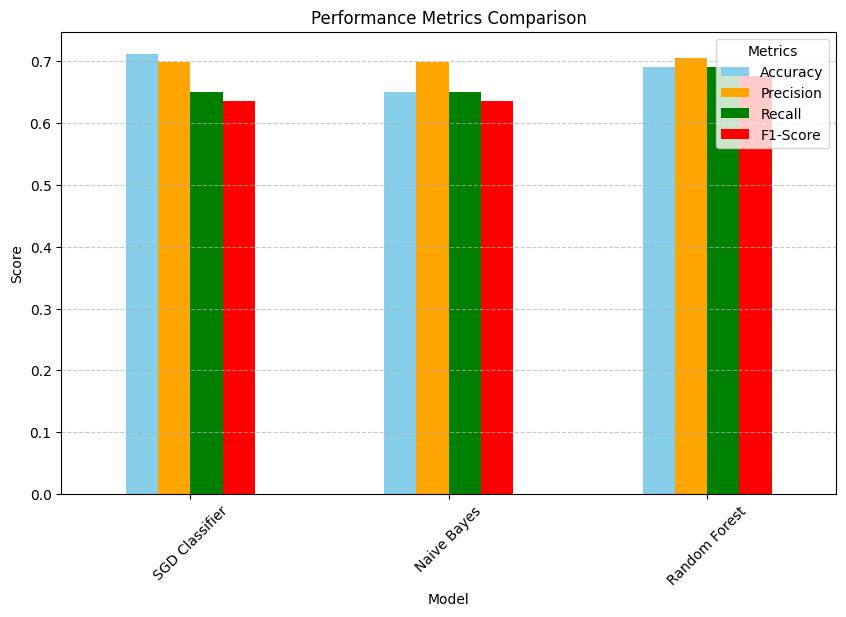

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Collect performance metrics for each model

# SGD Classifier metrics
sgd_accuracy = accuracy_score(y_test, sgd.predict(X_test_tfidf))
sgd_precision = precision_score(y_test, y_pred, average='weighted')
sgd_recall = recall_score(y_test, y_pred, average='weighted')
sgd_f1 = f1_score(y_test, y_pred, average='weighted')

# Naive Bayes metrics
nb_accuracy = accuracy_score(y_test, nb.predict(X_test_tfidf))
nb_precision = precision_score(y_test, nb.predict(X_test_tfidf), average='weighted')
nb_recall = recall_score(y_test, nb.predict(X_test_tfidf), average='weighted')
nb_f1 = f1_score(y_test, nb.predict(X_test_tfidf), average='weighted')

# Random Forest metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

# Combine metrics into a dictionary
metrics = {
    'Model': ['SGD Classifier', 'Naive Bayes', 'Random Forest'],
    'Accuracy': [sgd_accuracy, nb_accuracy, rf_accuracy],
    'Precision': [sgd_precision, nb_precision, rf_precision],
    'Recall': [sgd_recall, nb_recall, rf_recall],
    'F1-Score': [sgd_f1, nb_f1, rf_f1]
}
print(
    f"SGD Classifier - Accuracy: {sgd_accuracy}, Precision: {sgd_precision}, Recall: {sgd_recall}, F1-Score: {sgd_f1}\n"
    f"Naive Bayes - Accuracy: {nb_accuracy}, Precision: {nb_precision}, Recall: {nb_recall}, F1-Score: {nb_f1}\n"
    f"Random Forest - Accuracy: {rf_accuracy}, Precision: {rf_precision}, Recall: {rf_recall}, F1-Score: {rf_f1}\n"
)
# Convert to DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics)

# Plot the metrics
metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange', 'green', 'red'])
plt.title('Performance Metrics Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

SGD Classifier - Accuracy: 0.7123837493881546, Precision: 0.6987489230003211, Recall: 0.6502202643171806, F1-Score: 0.636419117802274
Naive Bayes - Accuracy: 0.6502202643171806, Precision: 0.6987489230003211, Recall: 0.6502202643171806, F1-Score: 0.636419117802274
Random Forest - Accuracy: 0.6910425844346549, Precision: 0.7055219708759508, Recall: 0.6910425844346549, F1-Score: 0.6766653252316424



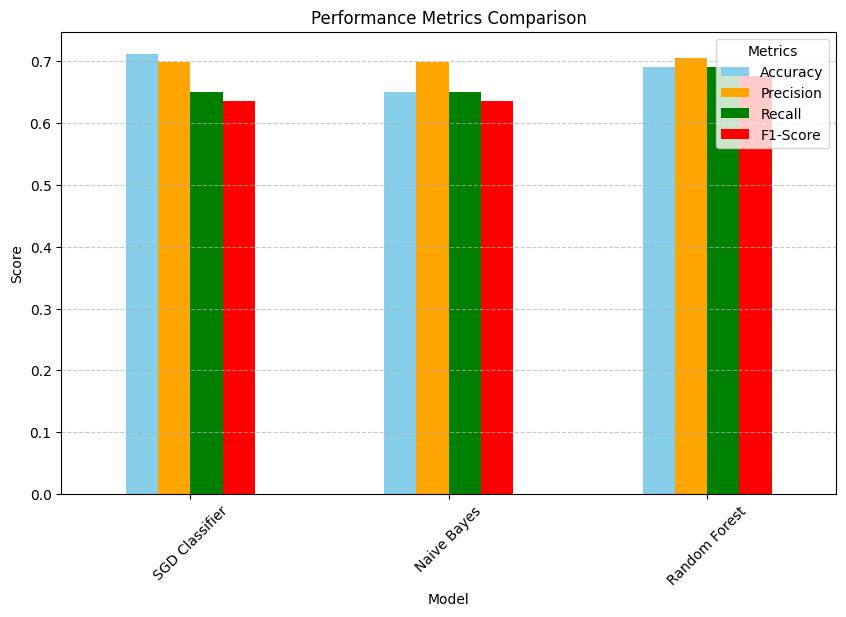

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Collect performance metrics for each model

# SGD Classifier metrics
sgd_accuracy = accuracy_score(y_test, sgd.predict(X_test_tfidf))
sgd_precision = precision_score(y_test, y_pred, average='weighted')
sgd_recall = recall_score(y_test, y_pred, average='weighted')
sgd_f1 = f1_score(y_test, y_pred, average='weighted')

# Naive Bayes metrics
nb_accuracy = accuracy_score(y_test, nb.predict(X_test_tfidf))
nb_precision = precision_score(y_test, nb.predict(X_test_tfidf), average='weighted')
nb_recall = recall_score(y_test, nb.predict(X_test_tfidf), average='weighted')
nb_f1 = f1_score(y_test, nb.predict(X_test_tfidf), average='weighted')

# Random Forest metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')

# Combine metrics into a dictionary
metrics = {
    'Model': ['SGD Classifier', 'Naive Bayes', 'Random Forest'],
    'Accuracy': [sgd_accuracy, nb_accuracy, rf_accuracy],
    'Precision': [sgd_precision, nb_precision, rf_precision],
    'Recall': [sgd_recall, nb_recall, rf_recall],
    'F1-Score': [sgd_f1, nb_f1, rf_f1]
}
print(
    f"SGD Classifier - Accuracy: {sgd_accuracy}, Precision: {sgd_precision}, Recall: {sgd_recall}, F1-Score: {sgd_f1}\n"
    f"Naive Bayes - Accuracy: {nb_accuracy}, Precision: {nb_precision}, Recall: {nb_recall}, F1-Score: {nb_f1}\n"
    f"Random Forest - Accuracy: {rf_accuracy}, Precision: {rf_precision}, Recall: {rf_recall}, F1-Score: {rf_f1}\n"
)
# Convert to DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics)

# Plot the metrics
metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange', 'green', 'red'])
plt.title('Performance Metrics Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()